In [32]:
#import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster
import pandas as pd
import matplotlib.pyplot as plt

import os
import mpl_toolkits
from statistics import mean
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.utils
os.getcwd()
import pandas_profiling as pp
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 
import seaborn as sns
from scipy import stats

from scipy.spatial.distance import pdist, squareform
pd.set_option('display.max_columns', None)

In [33]:
#create initial dataframe from csv
#some data wrangling here to read the start_time and end_time columns as datetime objects
#rather than strings makes it easier to work with later on
df = pd.read_csv('US_Accidents_June20.csv', parse_dates = ['Start_Time', 'End_Time'])
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [34]:
(df['Weather_Condition'].value_counts())

Clear                       808202
Fair                        547721
Mostly Cloudy               488094
Overcast                    382485
Partly Cloudy               344815
                             ...  
Partial Fog / Windy              1
Widespread Dust / Windy          1
Heavy Smoke                      1
Snow and Thunder                 1
Thunder and Hail / Windy         1
Name: Weather_Condition, Length: 127, dtype: int64

In [35]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,2478818.00000,3513617.00000,3513617.00000,3513617.00000,1034799.00000,1034799.00000,3513617.00000,1250753.00000,3447885.00000,1645368.00000,3443930.00000,3457735.00000,3437761.00000,3059008.00000,1487743.00000
mean,208.02258,2.33993,36.54195,-95.79151,37.55758,-100.45598,0.28162,5975.38269,61.93512,53.55730,65.11427,29.74463,9.12264,8.21902,0.01598
std,20.76627,0.55219,4.88352,17.36877,4.86121,18.52879,1.55013,14966.24017,18.62106,23.77334,22.75558,0.83198,2.88588,5.26285,0.19283
min,200.00000,1.00000,24.55527,-124.62383,24.57011,-124.49783,0.00000,0.00000,-89.00000,-89.00000,1.00000,0.00000,0.00000,0.00000,0.00000
25%,201.00000,2.00000,33.63784,-117.44177,33.99477,-118.34399,0.00000,864.00000,50.00000,35.70000,48.00000,29.73000,10.00000,5.00000,0.00000
50%,201.00000,2.00000,35.91687,-91.02601,37.79736,-97.03438,0.00000,2798.00000,64.00000,57.00000,67.00000,29.95000,10.00000,7.00000,0.00000
75%,201.00000,3.00000,40.32217,-80.93299,41.05139,-82.10168,0.01000,7098.00000,75.90000,72.00000,84.00000,30.09000,10.00000,11.50000,0.00000
max,406.00000,4.00000,49.00220,-67.11317,49.07500,-67.10924,333.63000,9999997.00000,170.60000,115.00000,100.00000,57.74000,140.00000,984.00000,25.00000


In [36]:
df["Temperature(F)"].describe().apply(lambda x: format(x, 'f'))

count    3447885.000000
mean          61.935119
std           18.621057
min          -89.000000
25%           50.000000
50%           64.000000
75%           75.900000
max          170.600000
Name: Temperature(F), dtype: object

In [37]:
len(df['Weather_Condition'].unique())

128

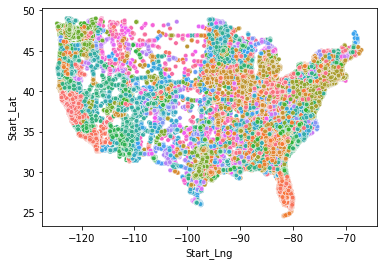

In [38]:
#map of accidents
sns.scatterplot(x='Start_Lng', y='Start_Lat', data = df, hue='County', legend=False, s=20)
plt.show()

In [39]:
df_cities = df.City.unique()
len(df_cities)
#"New York" in df.City.unique()

11896

In [40]:
city_by_accidents = df.City.value_counts()
city_by_accidents[:10]

Houston          101240
Los Angeles       79169
Charlotte         78952
Dallas            64790
Austin            63889
Raleigh           44675
Atlanta           41126
Oklahoma City     36340
Miami             34549
Baton Rouge       34090
Name: City, dtype: int64

<AxesSubplot:>

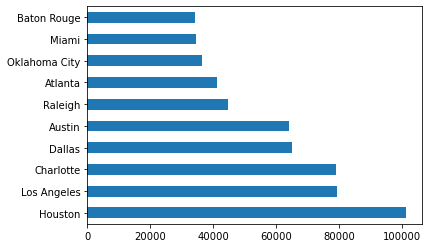

In [41]:
city_by_accidents[:10].plot(kind = 'barh')

<AxesSubplot:xlabel='City', ylabel='Density'>

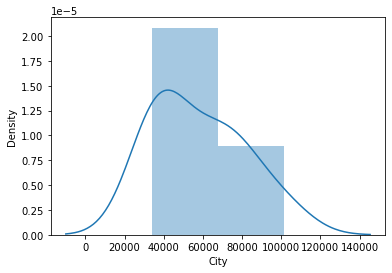

In [42]:
sns.distplot(city_by_accidents[:10])

In [43]:
high_acc_rate = city_by_accidents[city_by_accidents > 1000]
len(high_acc_rate)/len(df_cities)

0.049512441156691324

<AxesSubplot:xlabel='City', ylabel='Density'>

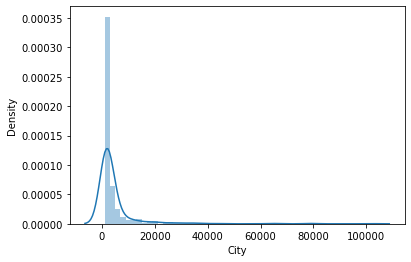

In [44]:
sns.distplot(high_acc_rate)

In [45]:
low_acc_rate = city_by_accidents[city_by_accidents < 1000]
len(low_acc_rate)/len(df_cities)

0.9504034969737727

<AxesSubplot:xlabel='City', ylabel='Density'>

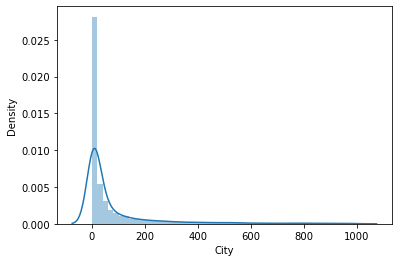

In [46]:
sns.distplot(low_acc_rate)

<AxesSubplot:xlabel='City', ylabel='Count'>

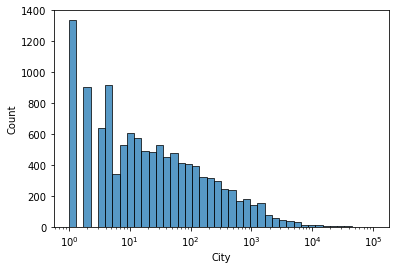

In [47]:
sns.histplot(city_by_accidents, log_scale=True)

In [48]:
pd.to_datetime(df.Start_Time)

0         2016-02-08 05:46:00
1         2016-02-08 06:07:59
2         2016-02-08 06:49:27
3         2016-02-08 07:23:34
4         2016-02-08 07:39:07
                  ...        
3513612   2019-08-23 18:03:25
3513613   2019-08-23 19:11:30
3513614   2019-08-23 19:00:21
3513615   2019-08-23 19:00:21
3513616   2019-08-23 18:52:06
Name: Start_Time, Length: 3513617, dtype: datetime64[ns]

In [49]:
states = list(df.State.unique())
state_det = {"Total accidents": [], "Severity(%) 1": [], "Severity(%) 2": []
            , "Severity(%) 3": [], "Severity(%) 4": []}
for state in states:
    dum = df[df.State == state]
    tot_acci = dum.shape[0]
    
    state_det["Total accidents"].append(tot_acci)
    
    sev_cnt = dum[dum["Severity"]==1].shape[0]
    state_det["Severity(%) 1"].append(sev_cnt/tot_acci*100)
    
    sev_cnt = dum[dum["Severity"]==2].shape[0]
    state_det["Severity(%) 2"].append(sev_cnt/tot_acci*100)
    
    sev_cnt = dum[dum["Severity"]==3].shape[0]
    state_det["Severity(%) 3"].append(sev_cnt/tot_acci*100)
    
    sev_cnt = dum[dum["Severity"]==4].shape[0]
    state_det["Severity(%) 4"].append(sev_cnt/tot_acci*100)
    
print("Frame listing total number of accidents in each state & percent of ")

frame = pd.DataFrame(state_det, index = states)
display(frame)

Frame listing total number of accidents in each state & percent of 


,Total accidents,Severity(%) 1,Severity(%) 2,Severity(%) 3,Severity(%) 4
OH,66139,0.795295,62.172092,28.582228,8.450385
WV,2381,0.083998,58.294834,21.167577,20.453591
CA,816825,0.710189,70.607780,27.646069,1.035962
FL,258002,1.168208,64.149115,31.225727,3.456950
GA,93614,0.433696,41.577115,50.032046,7.957143
SC,173277,0.066945,79.278265,19.979570,0.675219
NE,23970,0.158531,83.475177,15.173133,1.193158
IA,11475,0.052288,44.339869,47.581699,8.026144
IL,99692,0.265819,63.596878,32.752879,3.384424
MO,33643,0.208067,41.221056,53.544571,5.026306


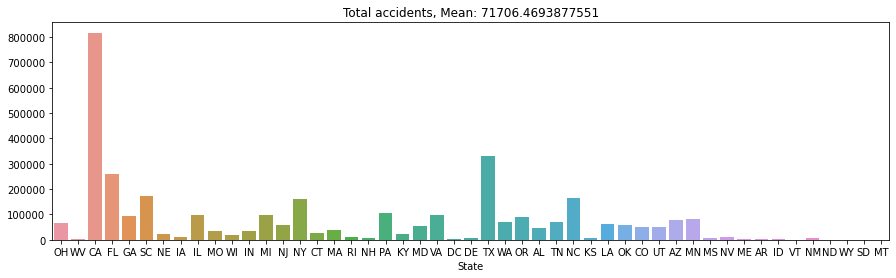

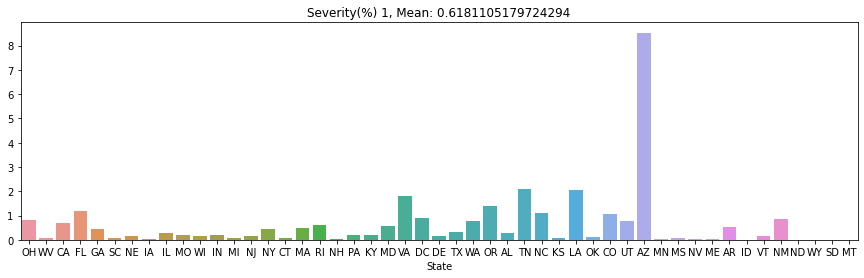

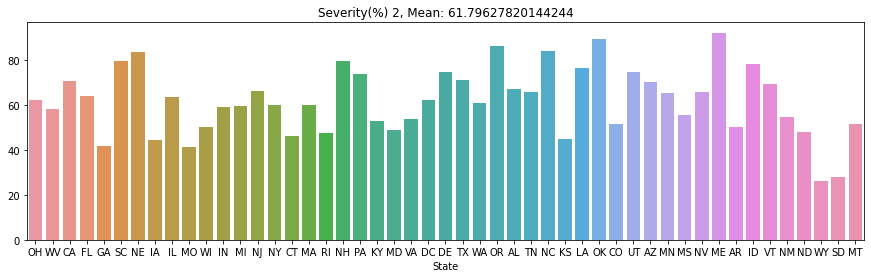

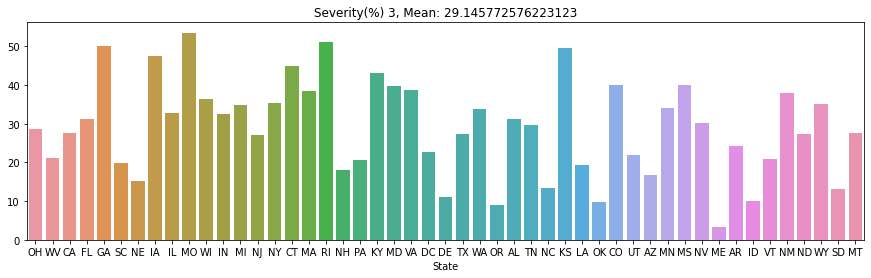

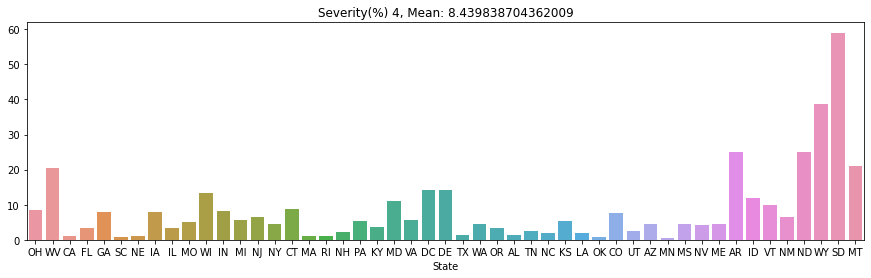

In [50]:
fig = plt.figure(figsize=(15,4))
sns.barplot(states, state_det["Total accidents"])
plt.xlabel("State")
mu = np.mean(state_det["Total accidents"])
plt.title("Total accidents, Mean: "+str(mu))
plt.show()

mu = np.mean(state_det["Severity(%) 1"])
fig = plt.figure(figsize=(15,4))
sns.barplot(states, state_det["Severity(%) 1"])
plt.xlabel("State")
plt.title("Severity(%) 1, Mean: "+str(mu))
plt.show()

mu = np.mean(state_det["Severity(%) 2"])
fig = plt.figure(figsize=(15,4))
sns.barplot(states, state_det["Severity(%) 2"])
plt.xlabel("State")
plt.title("Severity(%) 2, Mean: "+str(mu))
plt.show()

mu = np.mean(state_det["Severity(%) 3"])
fig = plt.figure(figsize=(15,4))
sns.barplot(states, state_det["Severity(%) 3"])
plt.xlabel("State")
plt.title("Severity(%) 3, Mean: "+str(mu))
plt.show()

mu = np.mean(state_det["Severity(%) 4"])
fig = plt.figure(figsize=(15,4))
sns.barplot(states, state_det["Severity(%) 4"])
plt.xlabel("State")
plt.title("Severity(%) 4, Mean: "+str(mu))
plt.show()

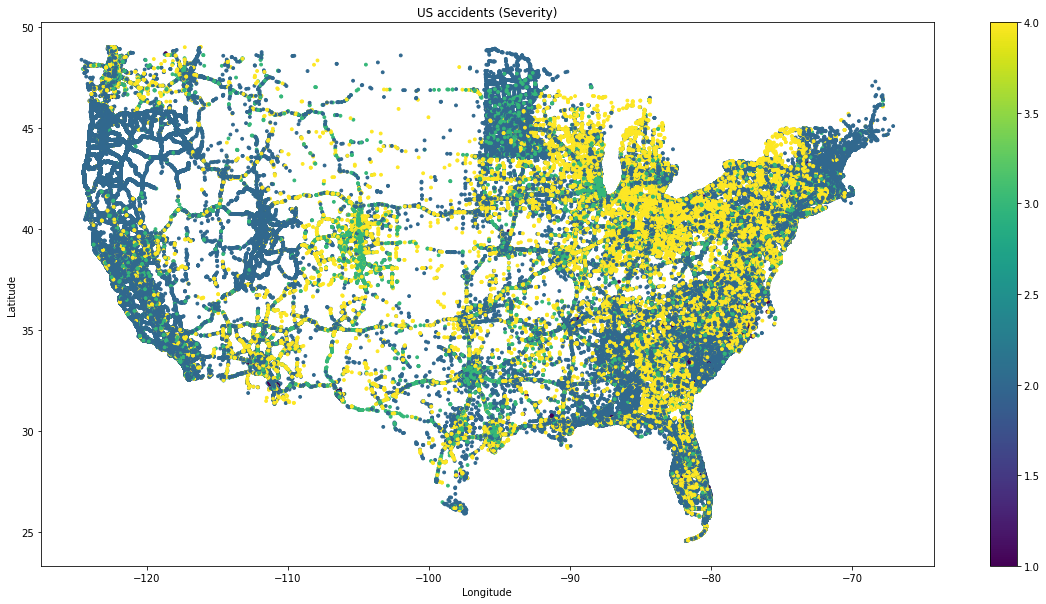

In [51]:
from matplotlib import cm

plt.figure(figsize=(20,10))

plt.scatter(df["Start_Lng"], df["Start_Lat"], s = 8, c = df["Severity"], 
           cmap = 'viridis')
plt.colorbar()

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("US accidents (Severity)")
plt.show()

{'US/Eastern': 1, 'US/Pacific': 2, 'US/Central': 3, 'US/Mountain': 4}


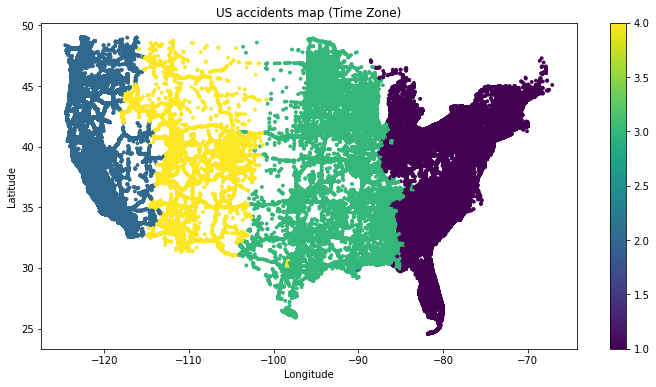

In [52]:
tz = df[["Start_Lng", "Start_Lat", "Timezone"]]
tz = tz.dropna()
tz_vals = list(tz['Timezone'].unique())

labels = {}
flag = 1
for arg in tz_vals:
    labels[arg] = flag
    flag += 1
print(labels)
colorbars = [labels[arg] for arg in tz["Timezone"]]

plt.figure(figsize=(12,6))

plt.scatter(tz['Start_Lng'], tz['Start_Lat'], s = 8, c = colorbars, cmap = 'viridis')
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("US accidents map (Time Zone)")
plt.show()

[]

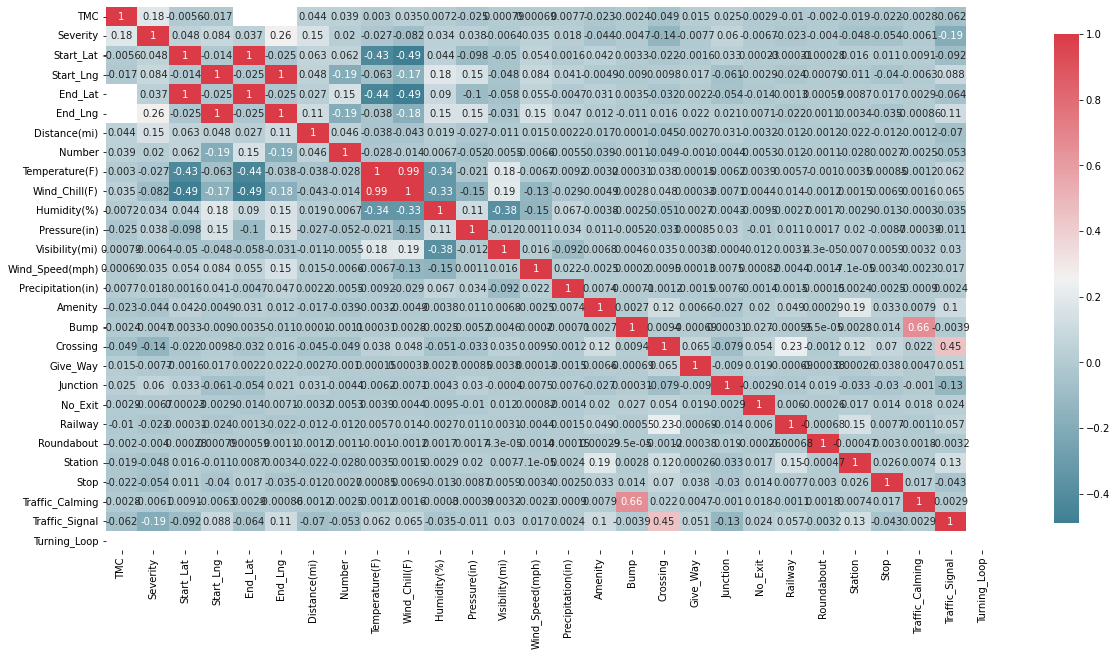

In [53]:
corr = df.corr()

f, ax = plt.subplots(figsize=(20,10))
g = sns.heatmap(corr, mask = np.zeros_like(corr, dtype=np.bool), 
               cmap = sns.diverging_palette(220, 10, as_cmap=True),
               square = False, ax=ax, annot=True, vmax = 1.0,
               cbar_kws={"shrink":0.9})
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.plot()

In [54]:
drop_list = ['Wind_Chill(F)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Country', 'Side','Street', 'City', 'County', 'State', 'Description', 'ID', 'Start_Time', 'End_Time', 'Source', 'TMC', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Number', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
                'Wind_Direction', 'Weather_Condition', 'Zipcode', 'Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight']
df_drop = df.drop(drop_list, axis = 1)

df_drop['month'] = df['Start_Time'].dt.month
df_drop['year'] = df['Start_Time'].dt.year
df_drop['hour'] = df['Start_Time'].dt.hour
df_drop['day'] = df['Start_Time'].dt.weekday
#for row in df_drop['Civil_Twilight']:
#    if row == 'Night':
#        df_drop['day_night'] = 0
#    else:
#        df_drop['day_night'] = 1

df_drop.head()
#df_drop = df_drop.dropna(subset=['Sunrise_Sunset'])
#df_drop = df_drop.dropna(subset=['Weather_Condition'])
df_drop = df_drop.dropna(subset=['Humidity(%)'])
df_drop = df_drop.dropna(subset=['Pressure(in)'])
df_drop = df_drop.dropna(subset=['Visibility(mi)'])
#df_drop = df_drop.dropna(subset=['Wind_Direction'])

df_drop.isna().sum()
df_drop_sev = df_drop[['Severity']].copy()

df_drop = df_drop.drop(['Severity'], axis = 1)
print(df_drop.shape)
print(df_drop_sev.shape)

import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=['Civil_Twilight'],return_df=True,
                           mapping=[{'col':'Civil_Twilight',
                            'mapping':{'Day':0,'Night':1}}])

df_transformed = encoder.fit_transform(df_drop)
df_transformed.head()

df_transformed.head()

(3418259, 24)
(3418259, 1)


,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Civil_Twilight,month,year,hour,day
0,39.865147,-84.058723,36.9,91.0,29.68,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,2,2016,5,0
1,39.928059,-82.831184,37.9,100.0,29.65,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,2,2016,6,0
2,39.063148,-84.032608,36.0,100.0,29.67,10.0,False,False,False,False,False,False,False,False,False,False,False,True,False,1.0,2,2016,6,0
3,39.747753,-84.205582,35.1,96.0,29.64,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,2,2016,7,0
4,39.627781,-84.188354,36.0,89.0,29.65,6.0,False,False,False,False,False,False,False,False,False,False,False,True,False,0.0,2,2016,7,0


In [55]:
print(df_transformed.shape)
print(df_drop_sev.shape)

(3418259, 24)
(3418259, 1)


In [56]:
#x_clmns = list(df.columns)
#x_clmns.remove("Severity")
#x_clmns.remove("City")
#x_clmns.remove("State")
#x_clmns.remove("ID")
#x_clmns.remove("Source")
#x_clmns.remove("End_Time")
#x_clmns.remove("Start_Time")
#x_clmns.remove("Description")
#x_clmns.remove("Street")
#x_clmns.remove("Side")

y_clmns=["Severity"]

x_clmns = list(df_transformed.columns)

X = df_transformed[x_clmns].values
y = df_drop_sev[y_clmns].values

y = np.reshape(y, (-1,1))
y = y[:,]

X_train, X_test, y_train, y_test = train_test_split(X, y[:, 0], test_size = 0.1, random_state = 21)

print("Train size: ", X_train.shape[0])
print("Test size: ", X_test.shape[0])

severity_count_y_test = {}
severity_count_y_test[1] = y_test[y_test == 1].shape[0]
severity_count_y_test[2] = y_test[y_test == 2].shape[0]
severity_count_y_test[3] = y_test[y_test == 3].shape[0]
severity_count_y_test[4] = y_test[y_test == 4].shape[0]

frame = pd.DataFrame(severity_count_y_test, index = ["Severity count in test_data"])
display(frame)

Train size:  3076433
Test size:  341826


,1,2,3,4
Severity count in test_data,2984,231279,96714,10849


In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 0, solver = 'saga', max_iter = 1000, verbose = 1, n_jobs = 5)
lr.fit(X_train, y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


max_iter reached after 3017 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed: 50.3min finished


LogisticRegression(max_iter=1000, n_jobs=5, random_state=0, solver='saga',
                   verbose=1)

In [ ]:
y_pred=lr.predict(X_train)
acc_train_lr = accuracy_score(y_train, y_pred)
print("Accuracy of train data:",acc_train_lr)

y_pred=lr.predict(X_test)
acc_test_lr=accuracy_score(y_test, y_pred)
print("Accuracy of test data:",acc_test_lr)

mat_lr = confusion_matrix(y_pred,y_test)
sns.heatmap(mat_lr, square=True, annot=True, fmt='d', cbar=False,xticklabels=[1,2,3,4],yticklabels=[1,2,3,4])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Confusion matrix")
plt.show()

frame=pd.DataFrame(severity_count_y_test,index=["Severity.count in test_data"])
display(frame)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier